# linear quadratic regulator - LQR

- here we presents robust optimal control LQR
- continuous version of LQR can be represented by following block diagram 
- controll action is computed from feedback gain matrix K and integral action gain matrix Ki
- input into controller is full state observation x, and required state xr
- output is input into plant
- controller works also for systems with multiple inputs and multiple outputs, and provides robust controll

![image](../../doc/diagrams/control-lqr.png)



## servo with inertia

- as controll example we choose DC motor servo with inertia (3rd order system)
- input is applied voltage, u
- output is full state, x, containing (angle, angular rate, motor current)

- dynamics described by differential equation, is rewritten into state space model

### todo - update for 3rd order

![image](../../doc/diagrams/control-servo.png)



In [7]:
import numpy
import scipy
import matplotlib.pyplot as plt


dt = 0.001 

# create dynamical system
# dx = Ax + Bu
# servo model, 3rd order
# state x = (position, angular velocity, current)

mat_a = numpy.zeros((3, 3))
mat_b = numpy.zeros((3, 1))

J = 0.02    #rotor moment of inertia (kg.m^2)
b = 0.2     #drag coefficient (N/m/s)
K = 0.3     #motor constant (N.m.A^-1)
R = 2.0     #wiring resitance, (ohm)
L = 0.4     #wiring inductance, (H)

mat_a[0][1] = 1.0

mat_a[1][1] = -b/J
mat_a[1][2] = K/J

mat_a[2][1] = -K/J
mat_a[2][2] = -R/L

mat_b[2][0] = 1.0/L

#print system dynamics
print(mat_a)
print(mat_b)

[[  0.   1.   0.]
 [  0. -10.  15.]
 [  0. -15.  -5.]]
[[0. ]
 [0. ]
 [2.5]]


## controller synthetis

- controll matrices are computed by solving algebraic Riccati equation
- input into solver are system matrices A, B, and loss weighting matrices Q and R
- matrix Q (mostly diagonal) penalises state elements deviation from required value
- matrix R (mostly diagonal) penalises control action amplitude


System matrices are expanded - augmented with integral terms, this step is necessary for completly removing steady state error and distrubance rejection.

![image](../../doc/diagrams/control-lqr_synth.png)

In [8]:
'''
solve the continuous time lqr controller.
dx = A x + B u
cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
'''
def solve_lqr(a, b, q, r):

    n = a.shape[0]  #system order
    m = b.shape[1]  #inputs count
    k = a.shape[0]  #outputs count

    #matrix augmentation with integral action
    a_aug = numpy.zeros((n+k, n+k))
    b_aug = numpy.zeros((n+k, m))
    q_aug = numpy.zeros((n+k, n+k))

    a_aug[0:n, 0:n] = a

    #add integrator into augmented a matrix
    a_aug[n:, 0:n]  = numpy.eye(n)

    b_aug[0:n,0:m]  = b

    #project Q matric to output, and fill augmented q matrix
    q_aug[n:, n:] = q

    # continuous-time algebraic Riccati equation solution
    p = scipy.linalg.solve_continuous_are(a_aug, b_aug, q_aug, r)

    # compute the LQR gain
    ki_tmp =  numpy.linalg.inv(r)@(b_aug.T@p)

    #truncated small elements
    ki_tmp[numpy.abs(ki_tmp) < 10**-10] = 0

    #split ki for k and integral action part ki
    k   = ki_tmp[:, 0:a.shape[0]]
    ki  = ki_tmp[:, a.shape[0]:]

    return k, ki


#create loss weighting matrices (diagonal)
q = numpy.array([ [1.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0] ] )
r = numpy.array( [ [0.001] ]) 

k, ki = solve_lqr(mat_a, mat_b, q, r)

print("k  = ", k)
print("ki = ", ki)
    

k  =  [[23.36070744  0.50904164  1.17938668]]
ki =  [[31.6227766  0.         0.       ]]


## testing controller

- the required state xr is set to (100deg, 0, 0), so the target angle position is 100degrees
- we initalise plant state into zero, and error integrator also as zero
- in for loop we run 1000 steps of simulation


- 1, error between required and observed state is measured
- 2, intergral action is computed
- 3, LQR controll action u is computed
- 4, motor dynamics is simulated


note : here we simulate plant by not accurate Euler method, however, for real systems, the Runge Kutta (RK4) method is much more accurate, especialy for oscilating or unstable dynamical systems

finally, we plot results

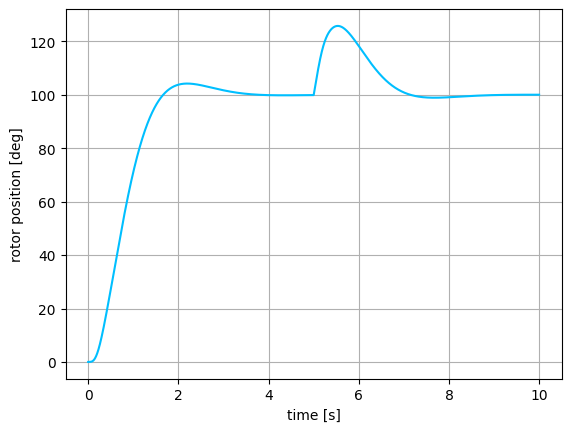

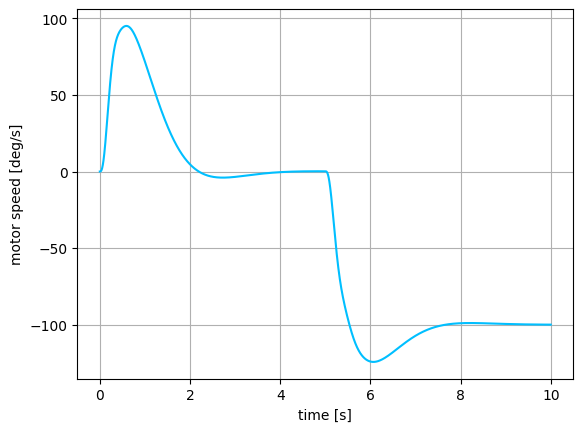

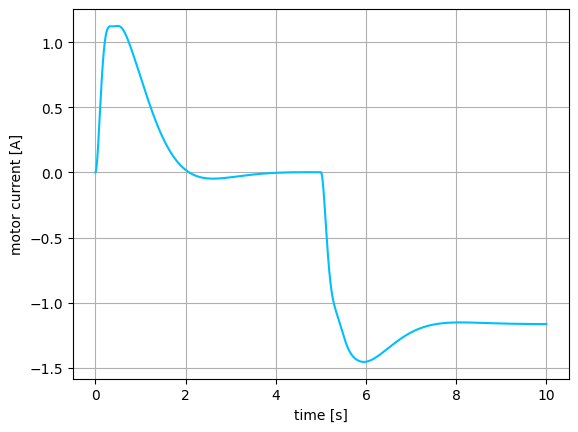

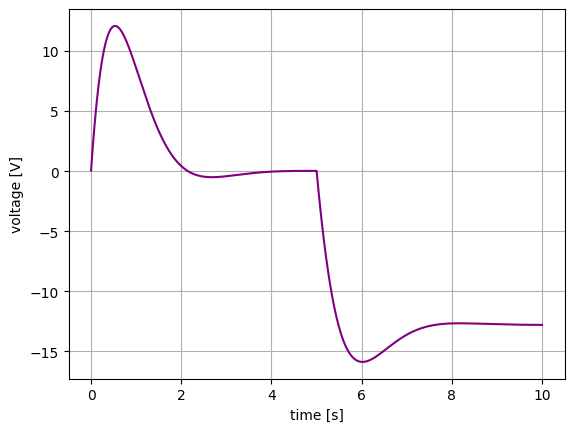

In [9]:
n_max = 10000

#required state, 100degrees
xr = numpy.zeros((mat_a.shape[0], 1))
xr[0][0] = 100.0*numpy.pi/180.0

#initial motor state
x         = numpy.zeros((mat_a.shape[0], 1))

#initial error integral
integral_action = numpy.zeros((mat_b.shape[1], 1))

#result log
t_result = []
u_result = []
x_result = []

for n in range(n_max):

    #integral action
    error = xr - x
    integral_action+= ki@error*dt

    #LQR controll law
    u = -k@x + integral_action

    #compute plant output
    #primitive euler method for integration
    dx = mat_a@x + mat_b@u
    x+= dx*dt

    #add constant distrubance in middle
    if n > n_max//2:
        x[0]+= 0.1*numpy.pi/180.0

    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())
    
    

x_result = numpy.array(x_result)
u_result = numpy.array(u_result)

# plot results
# angles convert into degrees


plt.clf()
plt.plot(t_result, x_result[:, 0]*180.0/numpy.pi, color="deepskyblue")
plt.xlabel("time [s]")
plt.ylabel("rotor position [deg]")
plt.grid()
plt.show()


plt.clf()
plt.plot(t_result, x_result[:, 1]*180.0/numpy.pi, color="deepskyblue")
plt.xlabel("time [s]")
plt.ylabel("motor speed [deg/s]")
plt.grid()
plt.show()


plt.clf()
plt.plot(t_result, x_result[:, 2], color="deepskyblue")
plt.xlabel("time [s]")
plt.ylabel("motor current [A]")
plt.grid()
plt.show()


plt.clf()
plt.plot(t_result, u_result[:], color="purple")
plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.grid()
plt.show()

## results
- first graph presents servo angle, how it achieve required 100degrees
- on middle time, the distrubance is generated (e.g. external kick or force), and demostrates how controller react for disturbance, and reject it by counteraction

- figures 2, 3 shows rotor speed and coil current
- last figure shows control input u

## meaning of integral action

- LQR using only matrix K, and some gain of error, is unable to reject distrubance
- integral action removes distrubance and steady state error
- also control variable u kick is removed

![image](../../doc/diagrams/control-lqr_comp.png)